# 📦 Warehouse Bin Assignment with 1:1 Mapping and Market Basket Grouping

In [10]:
import pandas as pd
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary, value
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
materials = pd.read_csv("clustered_materials_data.csv")
bins = pd.read_csv("expanded_bins_data.csv")


In [15]:
cluster_bin_map = {
    'Fragile-high value': ['safe'],
    'Fragile-others': ['safe'],
    'Oil Filled': ['special'],
    'Hazardous': ['special'],
    'Bulky slow movers': ['bulk', 'regular'],
    'Heavy duty': ['regular', 'reinforced'],
    'High and medium moving small parts': ['safe', 'regular'],
    'Affinity groups': ['safe', 'regular'],
    'Seasonal group (Nov-Jan)': ['regular', 'safe'],
    'Bulk consumables': ['bulk'],
    'other small parts': ['regular'],
    'other slow movers': ['regular'],
    'misclanious': ['regular'],
    'high movers': ['safe', 'regular'],
    'medium movers': ['regular']
}


In [16]:
compatibility = {}
for _, item in materials.iterrows():
    allowed_types = cluster_bin_map.get(item['cluster'], [])
    for _, b in bins.iterrows():
        compatibility[(item['material'], b['bin'])] = 1 if b['type'] in allowed_types else 0


In [17]:
affinity_pairs = [('M1', 'M5'), ('M3', 'M8'), ('M4', 'M9')]  # example co-picked items


In [18]:
model = LpProblem("Strict1to1BinAssignment", LpMinimize)
x = LpVariable.dicts("assign", (materials['material'], bins['bin']), cat=LpBinary)

# Objective: minimize distance * frequency
model += lpSum(x[i][b] * materials.set_index('material').loc[i, 'frequency'] *
               bins.set_index('bin').loc[b, 'distance']
               for i in materials['material'] for b in bins['bin'])

# Each material gets exactly one bin
for i in materials['material']:
    model += lpSum(x[i][b] for b in bins['bin']) == 1

# Each bin holds at most one material
for b in bins['bin']:
    model += lpSum(x[i][b] for i in materials['material']) <= 1

# Compatibility constraint
for i in materials['material']:
    for b in bins['bin']:
        model += x[i][b] <= compatibility[(i, b)]


In [19]:
affinity_penalty = 5  # encourage but don't force same bin
for (m1, m2) in affinity_pairs:
    for b1 in bins['bin']:
        for b2 in bins['bin']:
            if b1 != b2:
                model += x[m1][b1] + x[m2][b2] <= 1 + affinity_penalty


In [20]:
model.solve()

assignments = []
for i in materials['material']:
    for b in bins['bin']:
        if x[i][b].varValue == 1:
            print(f"{i} → {b}")
            assignments.append((i, b))

print("\\nTotal Weighted Distance:", value(model.objective))


M2 → B14
M3 → B7
M4 → B13
M5 → B11
M7 → B8
M8 → B6
M10 → B4
M11 → B12
M12 → B6
M13 → B6
M14 → B2
M15 → B15
\nTotal Weighted Distance: 106.0


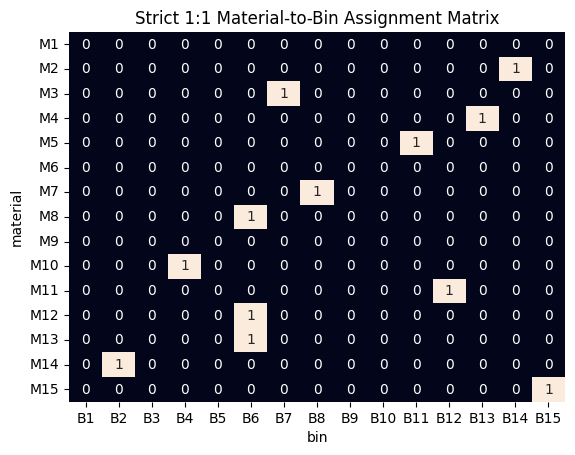

In [21]:
matrix = pd.DataFrame(0, index=materials['material'], columns=bins['bin'])
for i, b in assignments:
    matrix.loc[i, b] = 1

sns.heatmap(matrix, annot=True, cbar=False)
plt.title("Strict 1:1 Material-to-Bin Assignment Matrix")
plt.show()
